# Adding a background fit

Ran on 6 modes in: 2864 == 50 minutes.


In [1]:
import numpy as np
import matplotlib.pyplot as plt

import lightkurve as lk
from astropy.units import cds
from astropy import units as u

import corner
import pystan
import pickle
import os

Lets read in a handful of modes

In [59]:
locs = np.genfromtxt('../scripts/locs.txt')
mid = int(np.floor(len(locs)/2))
l0s = locs[mid:mid+2,0]
l1s = locs[mid:mid+2,1]
l2s = locs[mid-1:mid+1,2]

modelocs = np.array([l0s, l1s, l2s]).flatten()
modeids = [0]*len(l0s)  + [1]*len(l1s) + [2]*len(l2s)

In [60]:
ff = np.genfromtxt('../scripts/freqs.txt')
pp = np.genfromtxt('../scripts/model.txt')
sel = [(ff >= np.min(modelocs)-10) & (ff <= np.max(modelocs+10))]
f = ff[tuple(sel)]
p = pp[tuple(sel)] 

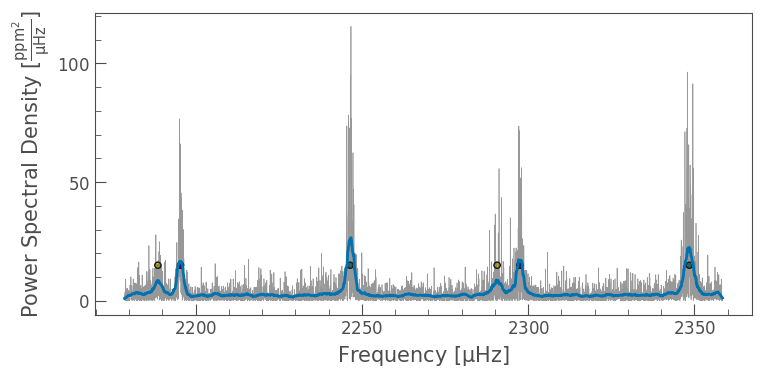

In [61]:
pg = lk.Periodogram(f*u.microhertz, p*(cds.ppm**2/u.microhertz))
ax = pg.plot(alpha=.5)
pg.smooth(filter_width=2.).plot(ax=ax, linewidth=2)
plt.scatter(modelocs, [15]*len(modelocs),c=modeids, s=20, edgecolor='k')
plt.show()

## Treating the background

We don't want to spend too much comptational effort on the background, so we're going to take the posteriors from our previous background fit and include these in a full covariance matrix as priors for those same parameters in this fit.

In [83]:
overwrite = True
malatium = '''
functions{      
    vector lorentzian(real loc, int l, int m, vector f, real eps, real H, real w, real nus){
        return (eps * H) ./ (1 + (4/w^2) * square(f - loc + m*nus));
    }
    real harvey(real f, real a, real b, real c){
        return 0.9*a^2/b/(1.0 + (f/b)^c);
    }
    real apod(real f, real nyq){
        real x = 3.14 / 2.0 * f / nyq;
        return (sin(x) / x)^2;
    }
    real background(real f, real a, real b, real c, real d, real j, real k,
                    real numax, real white, real nyq, real scale){
        return (apod(f, nyq) * scale
                * (harvey(f, a, b, 4.0)
                + harvey(f, c, d, 4.0)
                + harvey(f, j, k, 2.0))
                + white);
    }
}
data{
    int N;                   // Number of data points
    int M;                   // Number of modes
    vector[N] f;             // Frequency
    vector[N] p;             // Power
    real pr_locs[M];         // Mode locations (this will have to change for multiple n modes)
    real e_locs[M];          // Uncertainty on the mode locations
    int ids[M];              // The ID's of the modes
    real rho;                // The length scale of the GP Gamma prior
    vector[10] pr_phi;         // The initial guesses for the background parameters
    cov_matrix[10] sigphi;   // The covariance of the background parameters
}
transformed data{
    matrix[10,10] L_sigphi = cholesky_decompose(sigphi);
}
parameters{
    real logAmp[M];          // Mode amplitude in log space
    vector[M] logGamma;      // Mode linewidth in log space
    real locs[M];            // True mode locations
    real<lower=0> vsini;     //  Sin of angle of inclination x rotational splitting
    real<lower=0> vcosi;     //  Cos of angle of inclination x rotational splitting
    real<lower=0.> alpha;    // Spread on the squared exponential kernel
    vector[10] phi;            // The background parameters
}
transformed parameters{
    real numax = 10^phi[7];                // Background parameters
    real<lower=0> logac = phi[1] - phi[3]; // Background parameters
    real<lower=0> logdb = phi[4] - phi[2]; // Background parameters
    real H[M];                             // Mode height
    real w[M];                             // Mode linewidth
    real i;                                // Angle of inclination (rad)
    real<lower=0> nus;                     // Rotational frequency splitting
    matrix[M, M] gpG = cov_exp_quad(pr_locs, alpha, rho)
                        +diag_matrix(rep_vector(1e-10, M));
    matrix[M, M] LgpG = cholesky_decompose(gpG);
    
    
    nus = sqrt(vsini^2 + vcosi^2);         //Calculate the splitting
    i = acos(vcosi / nus);                 // Calculate the inclination
    
    for (m in 1:M){
        w[m] = 10^logGamma[m];             // Transform log linewidth to linewidth    
        H[m] = 10^logAmp[m] / pi() / w[m]; // Transform mode amplitude to mode height
    }
}
model{
    real a = 10^phi[1];          // Caculate the linear background parameters
    real b = 10^phi[2];
    real c = 10^phi[3];
    real d = 10^phi[4];
    real j = 10^phi[5];
    real k = 10^phi[6];
    vector[N] modes;             // Our Model
    matrix[4,4] eps;             // Matrix of legendre polynomials
    int l;                       // The radial degree
    real nus_mu = 0.5;            // Circumventing a Stan problem
    
    eps = rep_matrix(1., 4, 4);  // Calculate all the legendre polynomials for this i
    eps[0+1,0+1] = 1.;
    eps[1+1,0+1] = cos(i)^2;
    eps[1+1,1+1] = 0.5 * sin(i)^2;
    eps[2+1,0+1] = 0.25 * (3. * cos(i)^2 - 1.)^2;
    eps[2+1,1+1] = (3./8.)*sin(2*i)^2;
    eps[2+1,2+1] = (3./8.) * sin(i)^4;
    eps[3+1,0+1] = (1./64.)*(5.*cos(3.*i) + 3.*cos(i))^2;
    eps[3+1,1+1] = (3./64.)*(5.*cos(2.*i) + 3.)^2 * sin(i)^2;
    eps[3+1,2+1] = (15./8.)*cos(i)^2 * sin(i)^4;
    eps[3+1,3+1] = (5./16.)*sin(i)^6;    

        
    // Generating our model
    for (n in 1:N){
        modes[n] = background(f[n], a, b, c, d, j, k, numax, phi[8], phi[9], phi[10]);
    }
    
    for (mode in 1:M){        // Iterate over all modes passed in
        l = ids[mode];        // Identify the Mode ID
        for (m in -l:l){      // Iterate over all m in a given l
            modes += lorentzian(locs[mode], l, m, f, eps[l+1,abs(m)+1], H[mode], w[mode], nus);
        }
    }

    // Model drawn from a gamma distribution scaled to the model (Anderson+1990)
    p ~ gamma(1., 1../modes);
    
    //priors on the parameters
    logAmp ~ normal(1.5, 1.);
    locs ~ normal(pr_locs, e_locs);
    nus_mu ~ normal(nus, 1.);
    vsini ~ uniform(0,nus);
    
    alpha ~ normal(0.3, .5);
    logGamma ~ multi_normal_cholesky(rep_vector(0., M), LgpG);
    
    phi ~ multi_normal_cholesky(pr_phi, L_sigphi);
    logac ~ lognormal(1., 1.);
    logdb ~ lognormal(1., 1.);
}
'''
model_path = 'malatium.pkl'
if overwrite:
    print('Updating Stan model')
    sm = pystan.StanModel(model_code = malatium, model_name='malatium')
    pkl_file =  open(model_path, 'wb')
    pickle.dump(sm, pkl_file)
    pkl_file.close()
if os.path.isfile(model_path):
    print('Reading in Stan model')
    sm = pickle.load(open(model_path, 'rb'))
else:
    print('Saving Stan Model')
    sm = pystan.StanModel(model_code = malatium, model_name='malatium')
    pkl_file =  open(model_path, 'wb')
    pickle.dump(sm, pkl_file)
    pkl_file.close()

INFO:pystan:COMPILING THE C++ CODE FOR MODEL malatium_0f83241bdcec10c70cfc0fdacc516e6b NOW.


Updating Stan model
Reading in Stan model


Now lets try and read in the backfit output...

In [58]:
with open('backfit_sim.pkl', 'rb') as file:
    backfit = pickle.load(file)

In [55]:
labels=['loga','logb','logc','logd','logj','logk','lognumax','white','nyq','scale']
pr_phi = np.array([np.median(backfit[label]) for label in labels])
bf = pd.DataFrame(backfit)[labels]
sigphi = np.cov(bf.T)

In [62]:
nus = 0.411 #uHz
i = np.deg2rad(56.) #rad
dnu = 102. #uHz
d02 = 6.2 #uHz

data = {'N':len(f),
        'M': len(modelocs),
        'f':f,
        'p':p,
        'pr_locs':modelocs,
        'e_locs':np.ones(len(modelocs))*0.36,
        'ids':modeids,
        'rho':d02 * 5,
        'pr_phi':pr_phi,
        'sigphi':sigphi}

init = {'logAmp' :   np.ones(len(modelocs))*1.5,
        'logGamma': np.zeros(len(modelocs)),
        'vsini' : nus*np.sin(i),
        'vcosi' : nus*np.cos(i),
        'i' : i,
        'nus': nus,
        'locs' : modelocs,
        'alpha':.3,
        'phi':pr_phi}

In [63]:
nchains = 4
fit = sm.sampling(data=data, iter=2000, chains=nchains, seed=1895,
                  init = [init for n in range(nchains)])

In [64]:
print(fit)

Inference for Stan model: gpgamma_0f83241bdcec10c70cfc0fdacc516e6b.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

              mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
logAmp[1]     1.87  9.7e-4   0.06   1.76   1.83   1.87   1.91   1.98   3340    1.0
logAmp[2]     1.96  2.5e-3   0.05   1.86   1.93   1.96    2.0   2.07    453   1.01
logAmp[3]     2.16  7.0e-4   0.04   2.07   2.13   2.16   2.19   2.25   4034    1.0
logAmp[4]     2.21  1.3e-3   0.04   2.13   2.19   2.21   2.24   2.29    971   1.01
logAmp[5]      1.6  2.0e-3   0.07   1.47   1.55    1.6   1.64   1.72   1045    1.0
logAmp[6]     1.66 10.0e-4   0.06   1.54   1.62   1.66   1.71   1.78   3854    1.0
logGamma[1]  -0.05  1.5e-3   0.06  -0.18  -0.09  -0.05-3.1e-3   0.07   1683    1.0
logGamma[2]   0.08  1.8e-3   0.06  -0.04   0.04   0.08   0.13    0.2   1157    1.0
logGamma[3]-8.2e-3  1.0e-3   0.07  -0.15  -0.05-5.5e-3   0.04   0.1

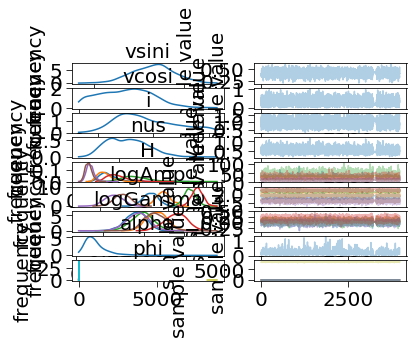

In [66]:
fit.plot(pars=['vsini','vcosi','i','nus','H','logAmp','logGamma','alpha','phi'])
plt.show()

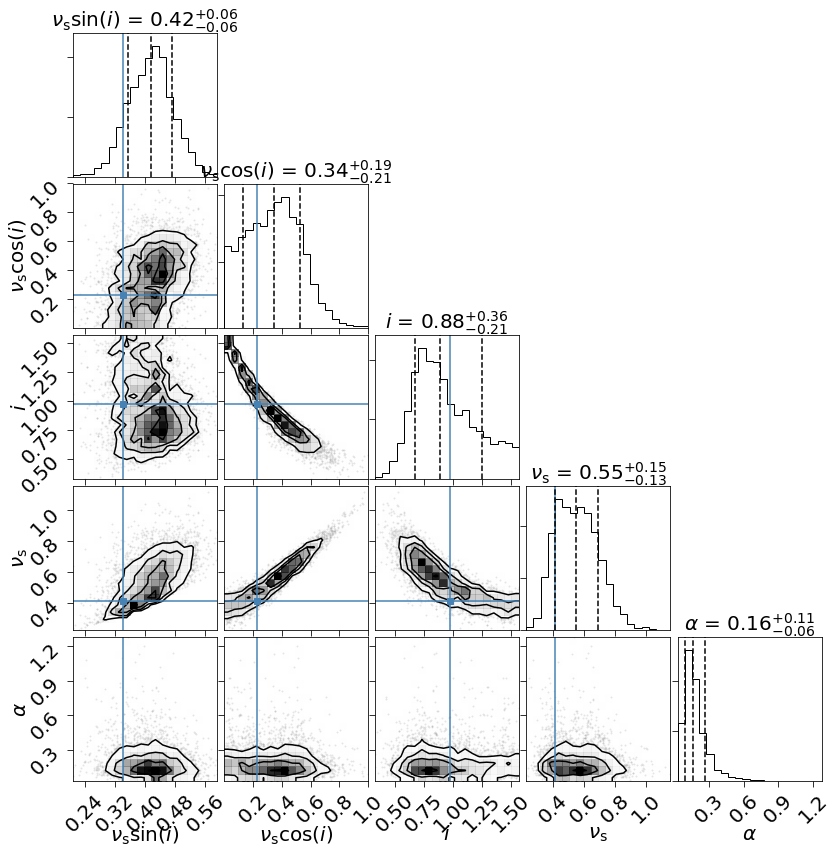

l = 0


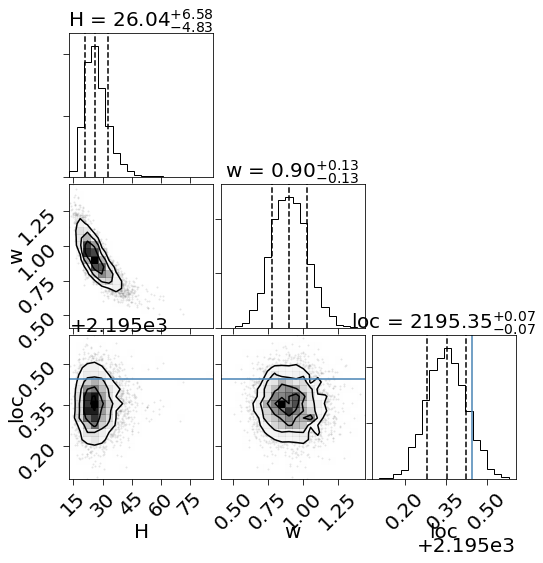

l = 0


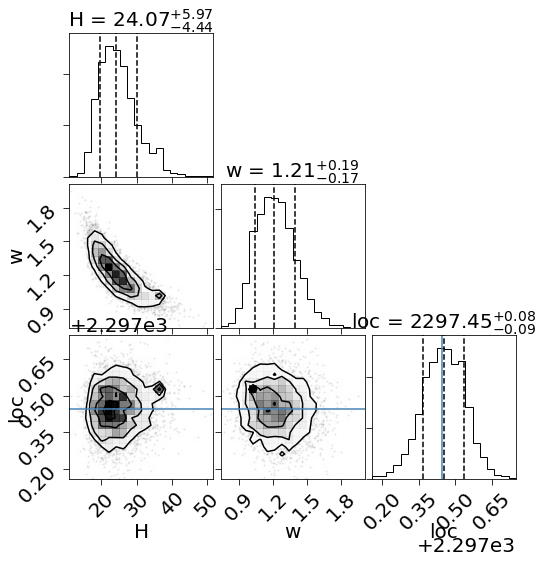

l = 1


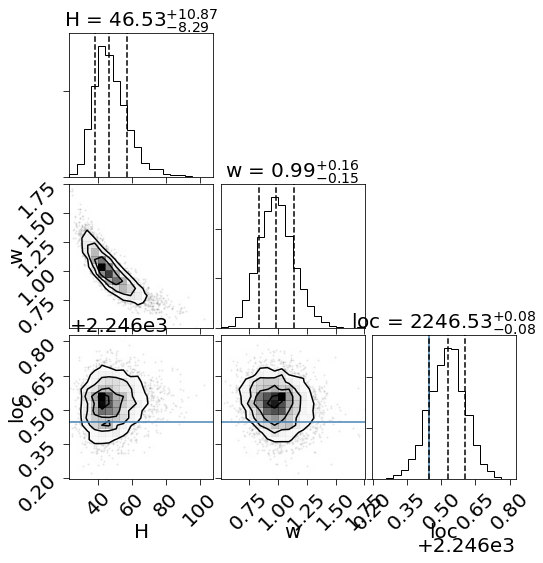

l = 1


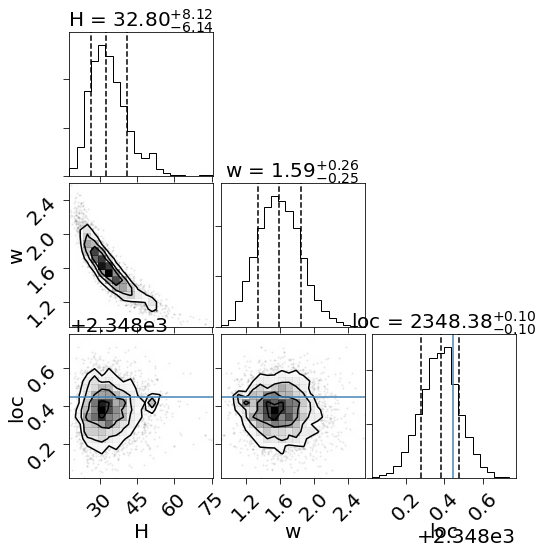

l = 2


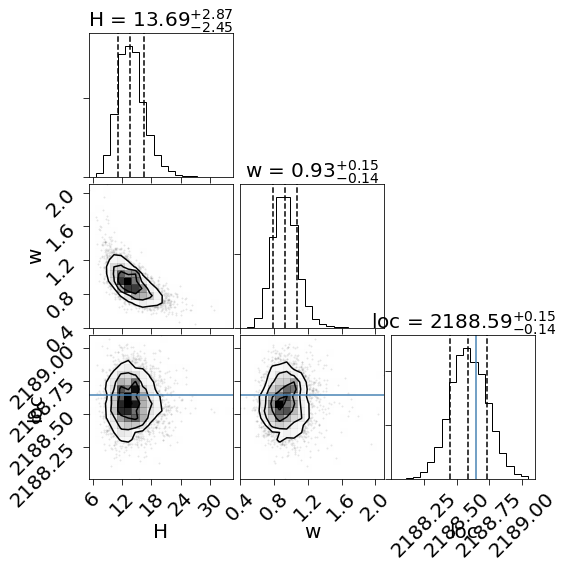

l = 2


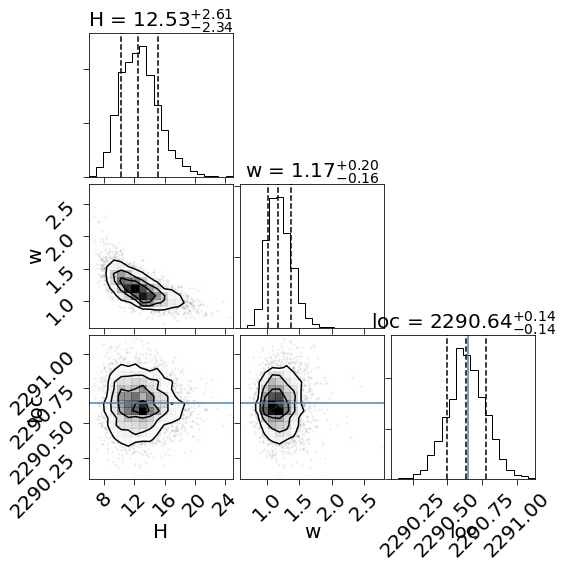

In [67]:
truths= [init['vsini'],init['vcosi'],init['i'],init['nus'], np.nan]
labels=['vsini','vcosi','i','nus', 'alpha']
chain = np.array([fit[label] for label in labels])
verbose = [r'$\nu_{\rm s}\sin(i)$',r'$\nu_{\rm s}\cos(i)$',r'$i$',
            r'$\nu_{\rm s}$', r'$\alpha$']
corner.corner(chain.T, labels=verbose, quantiles=[0.16, 0.5, 0.84],
            truths=truths,show_titles=True)
plt.show()

for idx in range(len(fit['H'].T)):
    truths = [np.nan, np.nan, data['pr_locs'][idx]]
    chain = np.array([fit['H'].T[idx], fit['w'].T[idx], fit['locs'].T[idx]])
    corner.corner(chain.T, labels=['H','w', 'loc'], truths=truths,
                  quantiles=[0.16, 0.5, 0.84],show_titles=True)
    print('l = {}'.format(modeids[idx]))   
    plt.show()

In [68]:
def get_epsilon(i, l, m):
#I use the prescriptions from Gizon & Solank 2003 and Handberg & Campante 2012
    if l == 0:
        return 1
    if l == 1:
        if m == 0:
            return np.cos(i)**2
        if np.abs(m) == 1:
            return 0.5 * np.sin(i)**2
    if l == 2:
        if m == 0:
            return 0.25 * (3 * np.cos(i)**2 - 1)**2
        if np.abs(m) ==1:
            return (3/8)*np.sin(2*i)**2
        if np.abs(m) == 2:
            return (3/8) * np.sin(i)**4
    if l == 3:
        if m == 0:
            return (1/64)*(5*np.cos(3*i) + 3*np.cos(i))**2
        if np.abs(m) == 1:
            return (3/64)*(5*np.cos(2*i) + 3)**2 * np.sin(i)**2
        if np.abs(m) == 2:
            return (15/8) * np.cos(i)**2 * np.sin(i)**4
        if np.abs(m) == 3:
            return (5/16)*np.sin(i)**6
    
def lorentzian(f, l, m, loc, i, H, w, nus):
    eps = get_epsilon(i,l,m)
    model = eps * H / (1 + (4/w**2)*(f - loc + m * nus)**2)
    return model

model = np.ones(len(f))
nus = np.median(fit['nus'])
for mode in range(len(modeids)):
    l = modeids[mode]
    for m in range(-l, l+1):
        loc = np.median(fit['locs'].T[mode])
        H = np.median(fit['H'].T[mode])
        w = np.median(fit['w'].T[mode])
        model += lorentzian(f, l, m, loc, i, H, w, nus)
fitlocs = np.median(fit['locs'],axis=0)

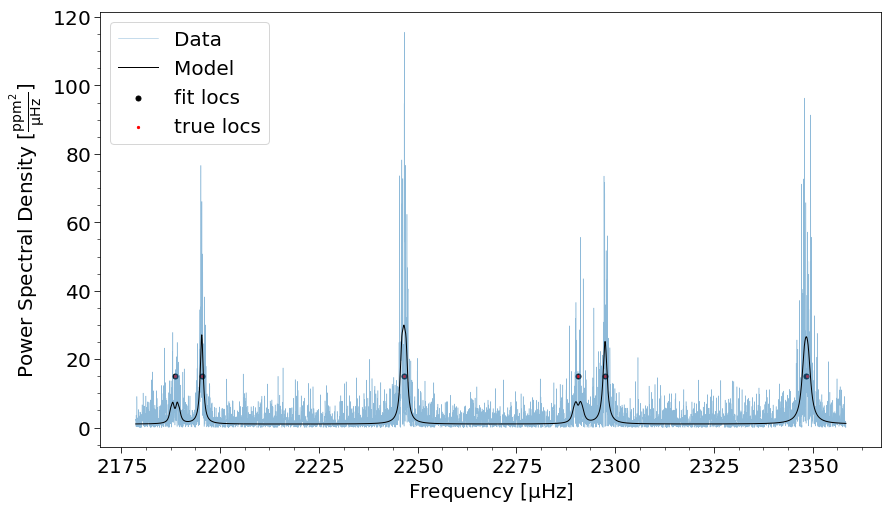

In [71]:
pg = lk.Periodogram(f*u.microhertz, p*(cds.ppm**2/u.microhertz))
fig, ax = plt.subplots(figsize=(14,8))
pg.plot(alpha=.5, label='Data',ax=ax)
plt.scatter(fitlocs, [15]*len(fitlocs),c='k',s=25, label='fit locs')
plt.scatter(modelocs, [15]*len(modelocs),c='r',s=5, label='true locs')
plt.plot(f, model, linewidth=1, label='Model',c='k')
plt.legend()

In [75]:
np.median(fit['phi'],axis=0).shape

(10,)

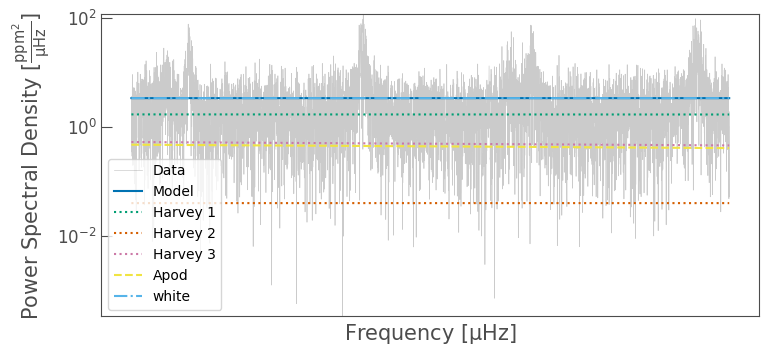

In [81]:
def harvey(f, a, b, c):
    harvey = 0.9*a**2/b/(1.0 + (f/b)**c);
    return harvey

def get_apodization(freqs, nyquist):
    x = (np.pi * freqs) / (2 * nyquist)
    return (np.sin(x)/x)**2

def get_background(f, a, b, c, d, j, k, white, numax, scale, nyq):
    background = np.zeros(len(f))
    background += get_apodization(f, nyq) * scale\
                    * (harvey(f, a, b, 4.) + harvey(f, c, d, 4.) + harvey(f, j, k, 2.))\
                    + white
    return background

def out_modelplot(fit):
    labels=['loga','logb','logc','logd','logj','logk','white','numax','scale','nyq']
    res = np.median(fit['phi'],axis=0)
    res[0:6] = 10**res[0:6]
    model = get_background(f, *res)

    pg = lk.Periodogram(f*u.microhertz, p*(cds.ppm**2/u.microhertz))
    ax = pg.plot(alpha=.25, label='Data', scale='log')
    ax.plot(f, model, label='Model')
    ax.plot(f, harvey(f, res[0],res[1], 4.), label='Harvey 1', ls=':')
    ax.plot(f, harvey(f, res[2],res[3], 4.), label='Harvey 2', ls=':')
    ax.plot(f, harvey(f, res[4],res[5], 2.), label='Harvey 3', ls=':')
    ax.plot(f, get_apodization(f, f[-1]), label='Apod', ls='--')
    ax.plot(f, res[-4]*np.ones_like(f), label='white',ls='-.')
    plt.legend(fontsize=10)
    ax.set_ylim(p.min(), p.max())
    plt.show()
out_modelplot(fit)

(-0.3, 0.3)

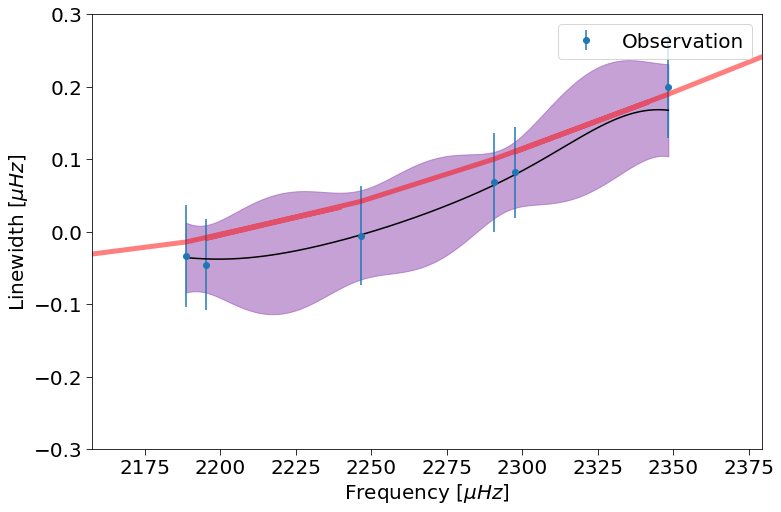

In [86]:
def kernel(x, y, p):
    ''' Returns a sqaured exponetial covariance matrix '''
    # p[0] = sigma
    # p[1] = length scale
    return p[0]**2 * np.exp(-0.5 * np.subtract.outer(x, y)**2 / p[1]**2)    

def predict(t_2, t_1, kernel, theta, a, c, y_1, y_v):
    B = kernel(t_1, t_2, theta).T
    A = kernel(t_1, t_1, theta).T + np.diag(y_v)
    C = kernel(t_2, t_2, theta).T
    
    y = c + np.dot(np.dot(B, np.linalg.inv(A)), (y_1 - a))
    Sigma = C - np.dot(np.dot(B, np.linalg.inv(A)),B.T)
            
    y_pred = y 
    sigma_new = np.sqrt(np.diagonal(Sigma))
    return y_pred, sigma_new

def plot_GP(ax, t_1, t_2, y_1, s, y_pred, sigmas, label='Observation'):
    ax.fill_between(t_2, y_pred-sigmas, y_pred+sigmas, alpha=.5, color='#8d44ad')
    ax.plot(t_2, y_pred, c='k')
    ax.errorbar(t_1, y_1, yerr=s, fmt='o', capsize=0, label=label)
    ax.legend(fontsize=15)
    ax.set_ylabel(r'Linewidth [$\mu Hz$]', fontsize=20)
    ax.set_xlabel(r'Frequency [$\mu Hz$]', fontsize=20)
    ax.legend(fontsize=20)
    return ax

ws = np.median(fit['logGamma'], axis=0)
ws_std = np.std(fit['logGamma'],axis=0)
flocs = np.median(fit['locs'], axis=0)
alpha = np.median(fit['alpha'])
rho = data['rho']

truths = np.genfromtxt('../scripts/lws.txt')

npts = 500

a = np.zeros(len(flocs))
c = np.zeros(npts)

flocs2 = np.linspace(np.min(flocs), np.max(flocs), npts)

theta = [alpha, rho]
ws_pred, sigmas = predict(flocs2, flocs, kernel, theta, a, c, ws, ws_std**2)

fig, ax = plt.subplots(figsize=(12,8))

ax = plot_GP(ax, flocs, flocs2, ws, ws_std, ws_pred, sigmas)
# ax.scatter(locs.flatten(), truths.flatten(), c='r', alpha=.5, marker='x',zorder=10)
ax.plot(locs.flatten(), np.log10(truths.flatten()), c='r', alpha=.5,lw=5, label='Truth')
ax.set_xlim(flocs.min()-5*d02, flocs.max()+5*d02)
ax.set_ylim(-.3, .3)

In [26]:
import sys
sys.exit()

SystemExit: 

/home/oliver/.local/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3273: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [70]:
print('We ran using: {} modes'.format(len(modelocs)))
print('It took {} seconds == {} hours'.format(2863.15, np.round(2863.15/60/60,2)))

We ran using: 6 modes
It took 2863.15 seconds == 0.8 hours
